In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp

In [181]:
# first demo -- gaussian mixture defined by the CRP


def build_static_dataset(N, beta=0.1):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    return x


def build_static_dataset_w_return(N, beta=0.1):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], np.diag(stds[0]))
    for n in range(1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, np.diag(stds[0]))
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], np.diag(stds[0]))
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, np.diag(stds[1]))
    return x

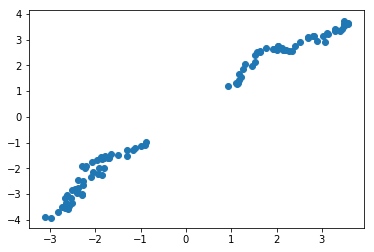

In [168]:
x_train = build_moving_data(100)
plt.scatter(x_train[:, 0], x_train[:, 1])

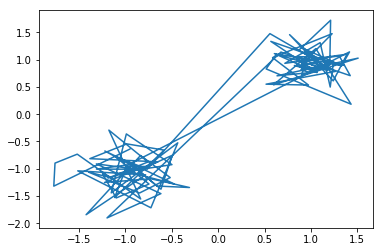

In [182]:
x_train = build_static_dataset_w_return(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [ ]:
class SEM(object):
    """
    This port of SAM's code (done with a different programming logic)
    in python. More documation to come!
    """
    
    def __init__(self, K=20, lmbda=1, alfa=10.0, beta=0.1, eta=0.1):

In [183]:
[N, D] = np.shape(x_train)

K = N # max cluster assignments
C = np.zeros(K, dtype=np.float32)
k = np.array([])

# just predefine theta with idendity matrix and zero bias....
theta = np.concatenate([np.zeros(D).flatten(), np.eye(D).flatten()])
theta = np.tile(theta, reps=(K, 1))

Sigma = np.eye(D) * beta  # noise for normal distribution...

def f_lin(X, theta):
    D = len(X)
    b = theta[0:D]
    w = theta[D:]
    Xp = b + np.matmul(X, np.reshape(w, (D, D)))
    
    #
    dXdb = np.eye(D)
    dXdW = np.tile((np.tile(X, (1, D))), (D, 1))
    g = np.concatenate([dXdb, dXdW], axis=1)
    
    return Xp, g
    
post = np.zeros((N, K))




K = 20  # maximum number of event types
lmda = 1  # stickyness parameter
alfa = 10.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate
_x = np.zeros(D) # it's a sequential model, no previous point (origin?) for the first data
_k = -1
for n in range(0, N):
    prior = C.copy()
    idx =  len(np.nonzero(C)[0])
    prior[idx] = alfa
    if n > 0: # no stickyness for the first timepoint
        prior[np.argmax(post[k,:])] + lmda
    
    prior /= np.sum(prior)
    
    # likelihood
    active = np.nonzero(prior)[0]
    lik = np.zeros(len(active))
    x = np.zeros((len(active), D))
    g = dict()
    for k in active:
        x[k, :], g[k] = f_lin(_x, theta=theta[k, :])
        lik[k] = np.log(multivariate_normal.pdf(x_train[n,:] - x[k, :], mean=[0, 0], cov=Sigma))
    
    # posterior
    p = np.log(prior[:len(active)]) + lik
    post[n, :len(active)] = np.exp(p - logsumexp(p))
    
    # update SEM parameters
    k = np.argmax(post[n, :])
    C[k] += 1
    theta[k, :] = theta[k, :] + eta * np.matmul(x_train[n, :] - x[k, :], g[k])
    _x = x_train[0, :].copy()


/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log


In [184]:
import seaborn as sns

IndexError: list index out of range

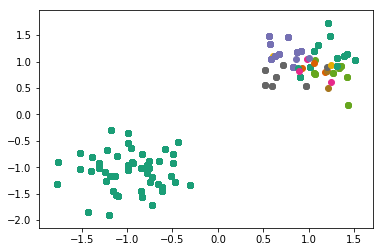

In [185]:
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', 20)
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])

In [189]:
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  0,  4,  2,  0,  5,  6,  2,  0,  7,  8,  9, 10, 11,
       12, 13, 14,  0, 15,  0, 12,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  2,
       12, 15, 15,  2,  0, 16, 17, 18, 19, 20, 15,  0, 15,  0, 12, 15,  2,
       12, 21,  2, 12,  2, 12,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

In [155]:
theta

array([[  7.80300424e-03,  -2.04303324e-02,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  2.61722580e-03,   2.61154622e-03,   1.00040800e+00,
         -1.06825550e-03,   4.08001302e-04,   9.98931744e-01],
       [  8.27633217e-03,   1.18995018e-02,   1.00157432e+00,
         -4.12198996e-03,   1.57432118e-03,   9.95878010e-01],
       [  1.53098963e-02,  -8.46100152e-03,   1.00053442e+00,
         -1.39925198e-03,   5.34419552e-04,   9.98600748e-01],
       [  2.10853197e-02,  -1.86573654e-02,   1.00018945e+00,
         -4.96039120e-04,   1.89453371e-04,   9.99503961e-01],
       [  1.73420824e-02,  -7.25011528e-03,   1.00078748e+00,
         -2.06182243e-03,   7.87476623e-04,   9.97938178e-01],
       [  3.68691154e-02,  -1.31910771e-02,   1.00184760e+00,
         -4.83750193e-03,   1.84759833e-03,   9.95162498e-01],
       [  4.48006876e-02,  -1.52847677e-02,   1.00230313e+00,
         -6.03020054e-03,   2.30312847e-03,   9.93969799e-01],
